# 1. GAN

## 1. 1 Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.optim.lr_scheduler as lr_scheduler
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os

# For GAN Evaluation
# https://datascience.stackexchange.com/questions/47875/why-is-my-generator-loss-function-increasing-with-iterations
# Device configuration


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())


True


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##1.2 Data Handling

In [3]:
file_path = '/content/drive/MyDrive/ProjectGAN/train_data.csv'
data = pd.read_csv(file_path)

data = data.fillna(0)
scaler = StandardScaler()
data.iloc[:, :-1] = scaler.fit_transform(data.iloc[:, :-1])

tensor_data = torch.tensor(data.values, dtype=torch.float32)
labels = tensor_data[:, -1].unsqueeze(1)
features = tensor_data[:, :-1]

train_dataset = TensorDataset(features, labels)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)


## 1.3 Generator Model

In [4]:
class Generator(nn.Module):
    def __init__(self, latent_dim, output_dim, class_dim):
        super(Generator, self).__init__()
        self.label_emb = nn.Embedding(class_dim, class_dim)
        self.model = nn.Sequential(
            nn.Linear(latent_dim + class_dim, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            nn.Linear(128, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm1d(256),
            nn.Dropout(0.3),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm1d(512),
            nn.Linear(512, output_dim),
            nn.Tanh(),
        )

    def forward(self, z, labels):
        c = self.label_emb(labels)
        c = c.view(-1, class_dim)
        x = torch.cat([z, c], dim=1)
        return self.model(x)



## 1.4 Discriminator Model

In [5]:
class Discriminator(nn.Module):
    def __init__(self, input_dim, class_dim):
        super(Discriminator, self).__init__()
        self.label_emb = nn.Embedding(class_dim, class_dim)
        self.model = nn.Sequential(
            nn.utils.spectral_norm(nn.Linear(input_dim + class_dim, 512)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.utils.spectral_norm(nn.Linear(512, 256)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x, labels):
        c = self.label_emb(labels)
        c = c.view(-1, class_dim)
        x = torch.cat([x, c], dim=1)
        return self.model(x)

## 1.5 Initialize the Generator and Discriminator

In [6]:
latent_dim = 100
output_dim = features.shape[1]
# output_dim = 100
class_dim = 2  # for binary classification
generator = Generator(latent_dim, output_dim, class_dim=class_dim).to(device)
discriminator = Discriminator(output_dim, class_dim=class_dim).to(device)


# print(generator)

## 1.6 Training Loop for GAN

[Epoch 1/15] [Batch 0/3110] [D loss: 2.541205406188965] [G loss: -0.4205591678619385]
[Epoch 1/15] [Batch 500/3110] [D loss: 1.016829252243042] [G loss: -0.36990296840667725]
[Epoch 1/15] [Batch 1000/3110] [D loss: 0.6264519691467285] [G loss: -0.380127876996994]
[Epoch 1/15] [Batch 1500/3110] [D loss: 0.9158082008361816] [G loss: -0.4550723433494568]
[Epoch 1/15] [Batch 2000/3110] [D loss: 0.8686596751213074] [G loss: -0.43178272247314453]
[Epoch 1/15] [Batch 2500/3110] [D loss: 0.5788942575454712] [G loss: -0.45345622301101685]
[Epoch 1/15] [Batch 3000/3110] [D loss: 0.7640206813812256] [G loss: -0.5313583612442017]
[Epoch 2/15] [Batch 0/3110] [D loss: 0.7361470460891724] [G loss: -0.46819132566452026]
[Epoch 2/15] [Batch 500/3110] [D loss: 0.9165812730789185] [G loss: -0.46604979038238525]
[Epoch 2/15] [Batch 1000/3110] [D loss: 1.0038580894470215] [G loss: -0.5031269788742065]
[Epoch 2/15] [Batch 1500/3110] [D loss: 0.624314546585083] [G loss: -0.5237486362457275]
[Epoch 2/15] [Bat

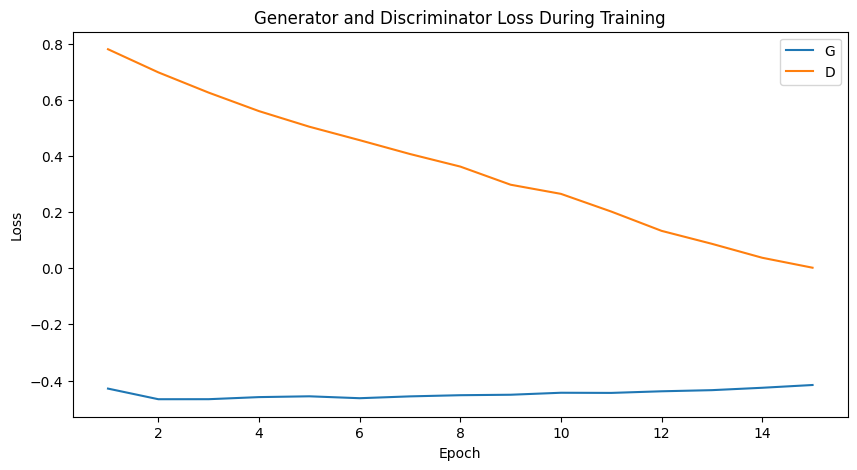

In [15]:
import torch
from torch import nn, optim
from torch.autograd import grad
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt

def compute_gradient_penalty(D, real_samples, fake_samples, labels, device):
    alpha = torch.rand(real_samples.size(0), 1, device=device)
    alpha = alpha.expand(real_samples.size())
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates, labels)
    fake = torch.ones(real_samples.shape[0], 1, device=device, requires_grad=False)
    gradients = grad(outputs=d_interpolates, inputs=interpolates,
                     grad_outputs=fake,
                     create_graph=True, retain_graph=True, only_inputs=True)[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty


def train_conditional_gan(generator, discriminator, dataloader, class_dim, device, latent_dim=100, num_epochs=15, model_path='gan_models'):
    lambda_gp = 10  # gsradient penalty coefficient
    optimizer_g = optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5, 0.999))
    optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0004, betas=(0.5, 0.999))

    if not os.path.exists(model_path):
        os.makedirs(model_path)

    G_losses = []
    D_losses = []
    epoch_G_losses = []
    epoch_D_losses = []
    n_critic = 5  # The number of discriminator updates per generator update

    for epoch in range(num_epochs):
        G_loss_accum = 0.0
        D_loss_accum = 0.0
        num_batches = 0
        for i, (real_samples, labels) in enumerate(dataloader):
            batch_size = real_samples.size(0)
            real_samples = real_samples.to(device)
            labels = labels.long().to(device)
            labels = labels.clamp(0, class_dim - 1)

            # Train Discriminator
            optimizer_d.zero_grad()
            z = torch.randn(batch_size, latent_dim, device=device)
            fake_samples = generator(z, labels).detach()
            real_validity = discriminator(real_samples, labels)
            fake_validity = discriminator(fake_samples, labels)
            d_loss_real = -torch.mean(real_validity)
            d_loss_fake = torch.mean(fake_validity)
            gradient_penalty = compute_gradient_penalty(discriminator, real_samples, fake_samples, labels, device)
            d_loss = d_loss_real + d_loss_fake + lambda_gp * gradient_penalty
            d_loss.backward()
            optimizer_d.step()

            # train the generator every n_critic steps
            if i % n_critic == 0:
                optimizer_g.zero_grad()
                fake_samples = generator(z, labels)
                validity = discriminator(fake_samples, labels)
                g_loss = -torch.mean(validity)
                g_loss.backward()
                optimizer_g.step()

            # accumulate the losses from each batch
            G_loss_accum += g_loss.item()
            D_loss_accum += d_loss.item()
            num_batches += 1

            G_losses.append(g_loss.item())
            D_losses.append(d_loss.item())

            if i % 500 == 0:
                print(f"[Epoch {epoch+1}/{num_epochs}] [Batch {i}/{len(dataloader)}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]")

        epoch_G_losses.append(G_loss_accum / num_batches)
        epoch_D_losses.append(D_loss_accum / num_batches)

    torch.save(generator.state_dict(), os.path.join(model_path, 'generator.pth'))
    torch.save(discriminator.state_dict(), os.path.join(model_path, 'discriminator.pth'))

    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(range(1, num_epochs + 1), epoch_G_losses, label="G")
    plt.plot(range(1, num_epochs + 1), epoch_D_losses, label="D")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    return generator, discriminator


#  the training process
trained_generator, trained_discriminator = train_conditional_gan(
    generator=generator,
    discriminator=discriminator,
    dataloader=train_dataloader,
    class_dim=class_dim,
    device=device,
    latent_dim=latent_dim,
    num_epochs=15,
)



##1.7 Evaluation of the Model

In [18]:
generator = Generator(latent_dim, output_dim, class_dim=class_dim)
generator.load_state_dict(torch.load('/content/gan_models/generator.pth'))
generator.eval()

Generator(
  (label_emb): Embedding(2, 2)
  (model): Sequential(
    (0): Linear(in_features=102, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=256, bias=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=256, out_features=512, bias=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Linear(in_features=512, out_features=30, bias=True)
    (12): Tanh()
  )
)

In [19]:
import torch
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

latent_dim = 100  # or the dimension used during training
class_dim = class_dim

real_data_df = pd.read_csv('/content/drive/MyDrive/ProjectGAN/train_data.csv')
real_features = real_data_df.drop(columns=['Class', 'id'])

output_dim = 30  # trained model's output dimension

# Load the trained generator model
generator = Generator(latent_dim, output_dim, class_dim)
generator.load_state_dict(torch.load('/content/gan_models/generator.pth'))
generator.eval()
generator.to(device)

# Generate synthetic data
num_samples = min(len(real_features), 150000)
synthetic_labels = torch.randint(0, class_dim, (num_samples,), device=device)
latent_space_samples = torch.randn(num_samples, latent_dim, device=device)
generated_data = generator(latent_space_samples, synthetic_labels).detach().cpu()

feature_names = real_features.columns.tolist() + ['AdditionalFeature']

generated_data_df = pd.DataFrame(generated_data.numpy(), columns=feature_names)

generated_data_df = generated_data_df.drop(columns=['AdditionalFeature'])

generated_data_df['Class'] = synthetic_labels.cpu().numpy()

scaler = StandardScaler()
scaler.fit(real_features)
generated_data_scaled = scaler.transform(generated_data_df.drop('Class', axis=1))

generated_data_scaled_df = pd.DataFrame(generated_data_scaled, columns=real_features.columns)
generated_data_scaled_df['Class'] = generated_data_df['Class']

generated_data_scaled_df.replace([np.inf, -np.inf], np.nan, inplace=True)
generated_data_scaled_df.fillna(generated_data_scaled_df.mean(), inplace=True)

generated_data_scaled_df.to_csv('/content/gan_models/synthetic_data.csv', index=False)

data = pd.read_csv('/content/gan_models/synthetic_data.csv')
print(data.head())


         V1        V2        V3        V4        V5        V6        V7  \
0 -0.999314 -0.165363 -0.540083  0.995457 -0.892058  0.484096  0.887207   
1  0.986622 -0.576018  0.362323 -0.889339  0.842539 -0.738234 -0.681878   
2 -1.000409 -0.413094 -0.427429  0.977037 -0.385549  0.674538 -0.739095   
3  0.874431 -0.213070  0.413169 -0.771826  0.367733 -0.391336 -0.325612   
4 -0.992007  0.967937 -0.916125  0.823089 -0.996208  0.066894  0.143396   

         V8        V9       V10  ...       V21       V22       V23       V24  \
0  0.803362 -0.241913  0.278012  ... -0.169874 -0.306705 -0.064445  0.030324   
1 -0.264914 -0.010920  0.029817  ... -0.242028  0.541768  0.855856 -0.074514   
2  0.874763 -0.396735  0.251375  ... -0.286412 -0.217067  0.952817 -0.480762   
3 -0.483122  0.140092 -0.531321  ...  0.219633  0.391394  0.031580 -0.187409   
4  0.354876 -0.448256  0.185309  ... -0.323759 -0.471002 -0.006224  0.448213   

        V25       V26       V27       V28    Amount  Class  
0  0.66

In [20]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

synthetic_data_df = pd.read_csv('/content/gan_models/synthetic_data.csv')


real_data_df = pd.read_csv('/content/drive/MyDrive/ProjectGAN/train_data.csv').iloc[:200000]
# real_data_df = pd.read_csv('/content/drive/MyDrive/ProjectGAN/train_data.csv')

amount_values = real_data_df['Amount'].values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(-1, 1))

scaled_amount = scaler.fit_transform(amount_values)

real_data_df['Amount'] = scaled_amount.flatten()




## 1.8 Comparison Histogram


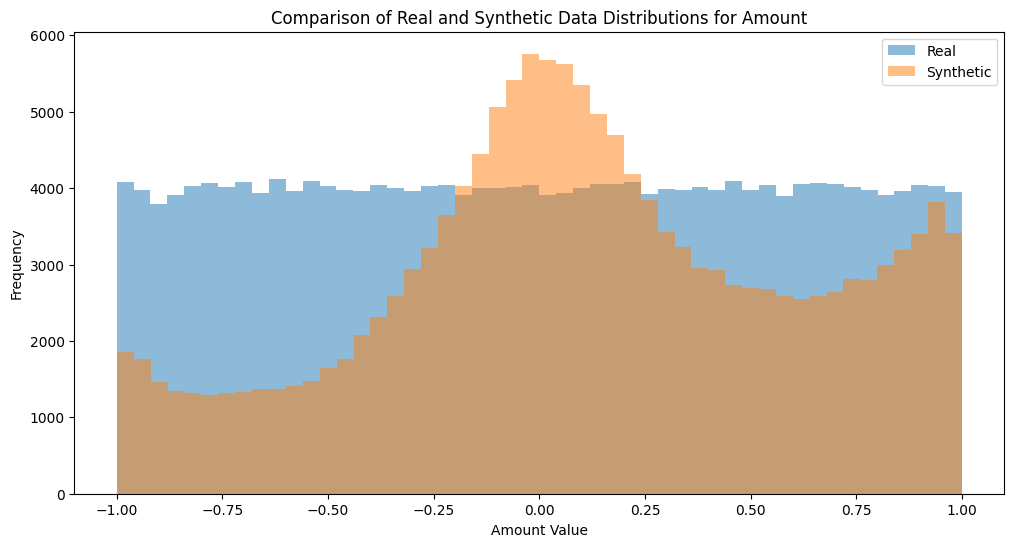

In [21]:
import matplotlib.pyplot as plt

def plot_comparison(feature):
    plt.figure(figsize=(12, 6))
    plt.hist(real_data_df[feature], bins=50, alpha=0.5, label='Real')
    plt.hist(synthetic_data_df[feature], bins=50, alpha=0.5, label='Synthetic')
    plt.xlabel(f'{feature} Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.title(f'Comparison of Real and Synthetic Data Distributions for {feature}')
    plt.show()

plot_comparison('Amount')


##1.9 Comparison Box Plot

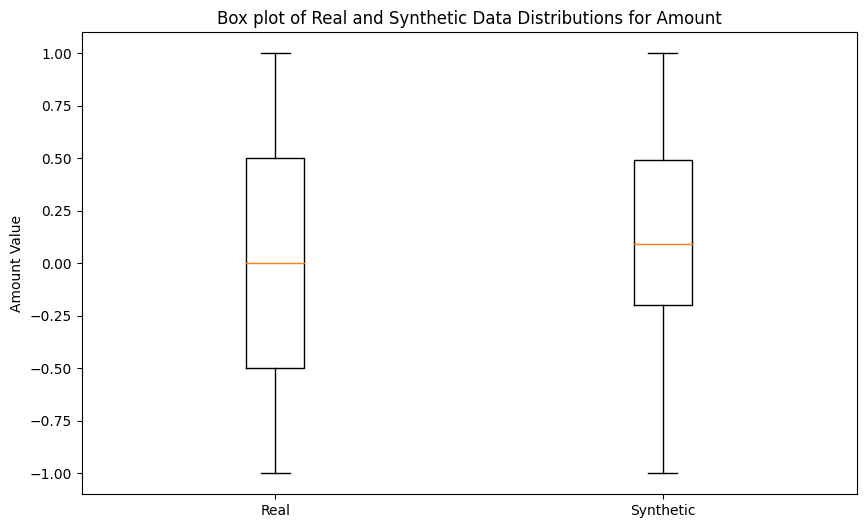

In [22]:
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(10, 6))
plt.boxplot([real_data_df['Amount'], generated_data_df['Amount']], labels=['Real', 'Synthetic'])
plt.title('Box plot of Real and Synthetic Data Distributions for Amount')
plt.ylabel('Amount Value')
plt.show()


## 1.10 KS Stat Test
### Closer to 0 means similar and closer to 1 means different

In [23]:
from scipy import stats
import pandas as pd

real_data_df = pd.read_csv('/content/drive/MyDrive/ProjectGAN/train_data.csv')
synthetic_data_df = pd.read_csv('/content/gan_models/synthetic_data.csv')

real_data_column = real_data_df['Amount']
synthetic_data_column = synthetic_data_df['Amount']

ks_statistic, p_value = stats.ks_2samp(real_data_column, synthetic_data_column)

print(f'KS Statistic: {ks_statistic}')
print(f'P-value: {p_value}')



KS Statistic: 0.23527805245703948
P-value: 0.0


# 2.0 Classifiers

## 2.1 Original Data Classifier

In [24]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

train_file_path = '/content/drive/MyDrive/ProjectGAN/Split_Data/train_data.csv'
test_file_path = '/content/drive/MyDrive/ProjectGAN/Split_Data/test_data.csv'
val_file_path = '/content/drive/MyDrive/ProjectGAN/Split_Data/val_data.csv'

def load_data(file_path):
    data = pd.read_csv(file_path)
    return data

def train_classifier(X_train, y_train):
    classifier = SVC()
    classifier.fit(X_train, y_train)
    return classifier

def evaluate_classifier(classifier, X_test, y_test):
    predictions = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    report = classification_report(y_test, predictions, output_dict=True)
    metrics = {
        'accuracy': accuracy,
        'precision': report['weighted avg']['precision'],
        'recall': report['weighted avg']['recall'],
        'f1_score': report['weighted avg']['f1-score']
    }
    print("Accuracy:", accuracy_score(y_test, predictions))
    print("Classification Report:\n", classification_report(y_test, predictions))
    return metrics

def main():
    train_data = load_data(train_file_path)
    test_data = load_data(test_file_path)

    X_train = train_data.drop('Class', axis=1)
    y_train = train_data['Class']
    X_test = test_data.drop('Class', axis=1)
    y_test = test_data['Class']

    classifier = train_classifier(X_train, y_train)

    original_metrics = evaluate_classifier(classifier, X_test, y_test)
    return original_metrics

original_metrics = main()



Accuracy: 0.9995913335923787
Classification Report:
               precision    recall  f1-score   support

        -1.0       1.00      1.00      1.00     74633
         1.0       1.00      1.00      1.00     74633

    accuracy                           1.00    149266
   macro avg       1.00      1.00      1.00    149266
weighted avg       1.00      1.00      1.00    149266

Accuracy: 0.9995913335923787
Classification Report:
               precision    recall  f1-score   support

        -1.0       1.00      1.00      1.00     74633
         1.0       1.00      1.00      1.00     74633

    accuracy                           1.00    149266
   macro avg       1.00      1.00      1.00    149266
weighted avg       1.00      1.00      1.00    149266



##2.2 Augmented Data (Original + Synthetic Data) Classifier

In [25]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.utils import shuffle

real_data_path = '/content/drive/MyDrive/ProjectGAN/Split_Data/train_data.csv'
synthetic_data_path = '/content/gan_models/synthetic_data.csv'

def load_data(file_path):
    data = pd.read_csv(file_path)
    return data


def clean_data(data):
    if 'Class' in data.columns:
        features = data.drop('Class', axis=1)
        target = data[['Class']]
    else:
        features = data
        target = None


    features.replace([np.inf, -np.inf], np.nan, inplace=True)

    imputer = SimpleImputer(strategy='mean')
    imputed_features = imputer.fit_transform(features)
    cleaned_features = pd.DataFrame(imputed_features, columns=features.columns)

    if target is not None:
        cleaned_data = pd.concat([cleaned_features, target.reset_index(drop=True)], axis=1)
    else:
        cleaned_data = cleaned_features

    return cleaned_data


def combine_datasets(real_data_path, synthetic_data_path):
    real_data = load_data(real_data_path)
    synthetic_data = load_data(synthetic_data_path)

    synthetic_data['Class'] = synthetic_data['Class'].replace({0: -1})

    print("Unique classes in real data:", real_data['Class'].unique())
    print("Unique classes in synthetic data after alignment:", synthetic_data['Class'].unique())

    real_data = clean_data(real_data)
    synthetic_data = clean_data(synthetic_data)

    combined_data = pd.concat([real_data, synthetic_data], ignore_index=True)
    combined_data = shuffle(combined_data, random_state=42)

    print("Unique classes in combined data after alignment:", combined_data['Class'].unique())

    return combined_data


def scale_data(X_train, X_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled

def train_classifier(X_train, y_train):
    classifier = SVC()
    classifier.fit(X_train, y_train)
    return classifier

def evaluate_classifier(classifier, X_test, y_test):
    predictions = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    report = classification_report(y_test, predictions, output_dict=True)
    metrics = {
        'accuracy': accuracy,
        'precision': report['weighted avg']['precision'],
        'recall': report['weighted avg']['recall'],
        'f1_score': report['weighted avg']['f1-score']
    }
    print("Accuracy:", accuracy_score(y_test, predictions))
    print("Classification Report:\n", classification_report(y_test, predictions))
    return metrics

def main():
    augmented_data = combine_datasets(real_data_path, synthetic_data_path)

    X = augmented_data.drop('Class', axis=1)
    y = augmented_data['Class']

    imputer = SimpleImputer(strategy='mean')
    X_imputed = imputer.fit_transform(X)
    X = pd.DataFrame(X_imputed, columns=X.columns)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train_scaled, X_test_scaled = scale_data(X_train, X_test)

    classifier = train_classifier(X_train_scaled, y_train)

    augmented_metrics = evaluate_classifier(classifier, X_test_scaled, y_test)
    return augmented_metrics

augmented_metrics = main()



Unique classes in real data: [ 1. -1.]
Unique classes in synthetic data after alignment: [-1  1]
Unique classes in combined data after alignment: [ 1. -1.]
Accuracy: 0.9997080505072622
Classification Report:
               precision    recall  f1-score   support

        -1.0       1.00      1.00      1.00     54964
         1.0       1.00      1.00      1.00     54644

    accuracy                           1.00    109608
   macro avg       1.00      1.00      1.00    109608
weighted avg       1.00      1.00      1.00    109608



##2.3 Synthetic Data Classifier

In [26]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

file_path = '/content/gan_models/synthetic_data.csv'

def load_data(file_path):
    data = pd.read_csv(file_path)
    return data

def evaluate_classifier(classifier, X_test, y_test):
    predictions = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    report = classification_report(y_test, predictions, output_dict=True)
    metrics = {
        'accuracy': accuracy,
        'precision': report['weighted avg']['precision'],
        'recall': report['weighted avg']['recall'],
        'f1_score': report['weighted avg']['f1-score']
    }
    print("Accuracy:", accuracy_score(y_test, predictions))
    print("Classification Report:\n", classification_report(y_test, predictions))
    return metrics

def main():
    synthetic_data = load_data(file_path)

    synthetic_data['Class'] = synthetic_data['Class'].replace({0: -1})

    X = synthetic_data.drop('Class', axis=1)
    y = synthetic_data['Class']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    classifier = SVC()
    classifier.fit(X_train, y_train)

    synthetic_metrics = evaluate_classifier(classifier, X_test, y_test)
    return synthetic_metrics

synthetic_metrics = main()



Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

          -1       1.00      1.00      1.00     14989
           1       1.00      1.00      1.00     15011

    accuracy                           1.00     30000
   macro avg       1.00      1.00      1.00     30000
weighted avg       1.00      1.00      1.00     30000



##2.4 Comparison of All 3 Classifiers

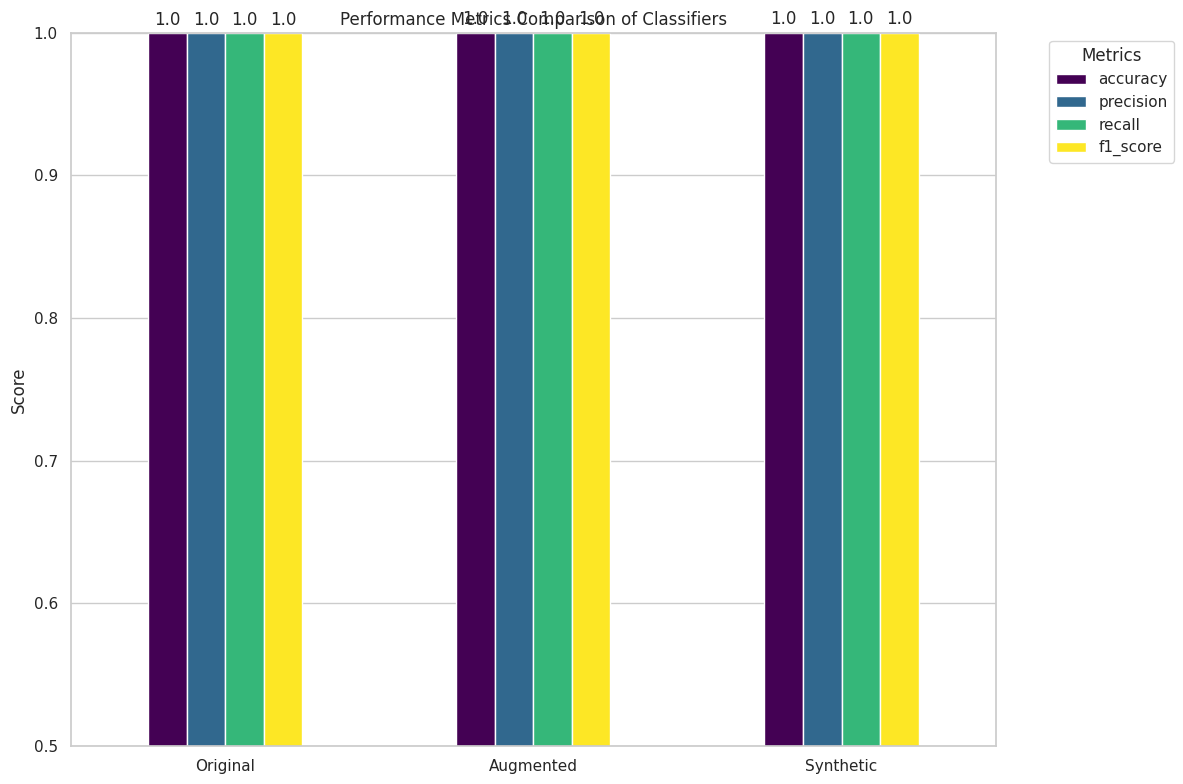

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


metrics_df = pd.DataFrame({
    'Original': original_metrics,
    'Augmented': augmented_metrics,
    'Synthetic': synthetic_metrics
})

metrics_df = metrics_df.T

sns.set_theme(style="whitegrid")
ax = metrics_df.plot(kind='bar', figsize=(12, 8), colormap='viridis')

plt.title('Performance Metrics Comparison of Classifiers')
plt.ylabel('Score')
plt.ylim(0.5, 1)
plt.xticks(rotation=0)
plt.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')

for p in ax.patches:
    ax.annotate(str(round(p.get_height(), 2)), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.tight_layout()
plt.show()
